In [200]:
import torch
import torchvision

from torch import nn
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

# Download Data

In [201]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [202]:
len(train_data), len(test_data)

(60000, 10000)

In [203]:
class_names = train_data.classes

class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [204]:
class_to_idx = train_data.class_to_idx

class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [205]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

image.shape: torch.Size([1, 28, 28])


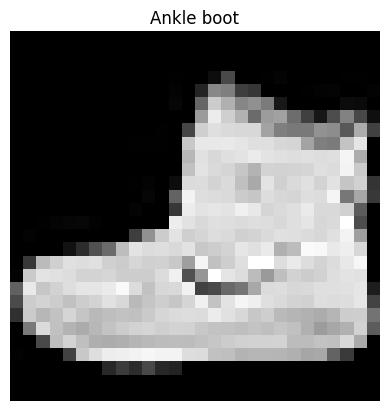

In [206]:
image, label = train_data[0]

print('image.shape:', image.shape)

plt.imshow(image.squeeze(), cmap='gray')
plt.title(class_names[label])
plt.axis('off')
plt.show()

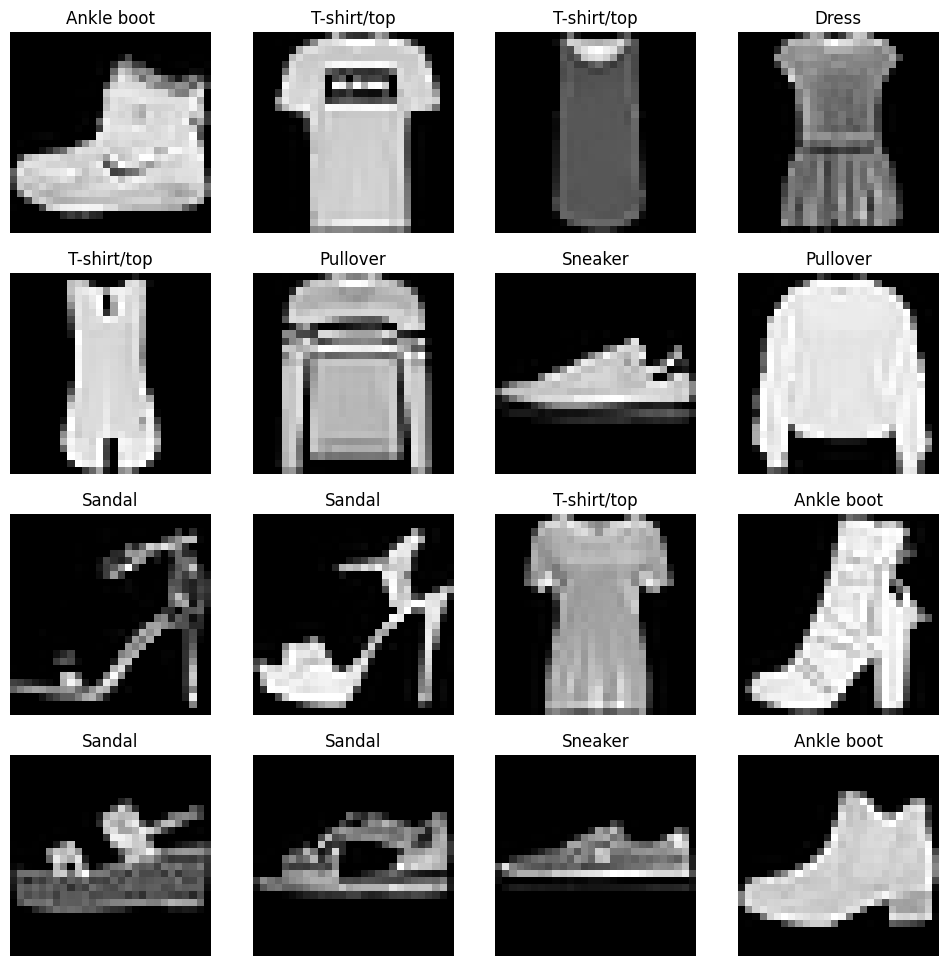

In [207]:
plt.figure(figsize=(12, 12))

for i in range(16):
    image, label = train_data[i]
    plt.subplot(4, 4, i + 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(class_names[label])
    plt.axis('off')

# DataLoader

In [208]:
from torch.utils.data import DataLoader

In [209]:
BATCH_SIZE = 32

In [210]:
train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    num_workers=4,
    shuffle=True
)

test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    num_workers=4,
    shuffle=False
)

In [211]:
train_dataloader.dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [212]:
len(train_dataloader), len(train_dataloader) * BATCH_SIZE

(1875, 60000)

In [213]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))

train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [214]:
torch.manual_seed(42)
rand_idx = torch.randint(0, len(train_features_batch), size=[1]).item()

In [215]:
img, label = train_features_batch[rand_idx], train_labels_batch[rand_idx]

In [216]:
img.shape

torch.Size([1, 28, 28])

In [217]:
img.squeeze().shape

torch.Size([28, 28])

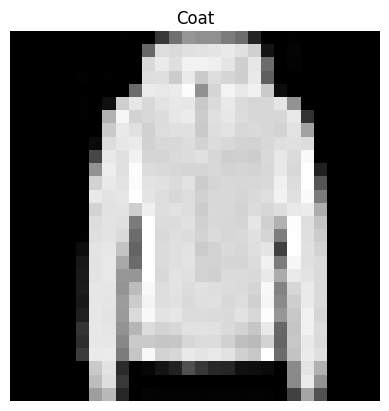

In [218]:
plt.imshow(img.squeeze(), cmap='gray')
plt.title(class_names[label.item()])
plt.axis('off')
plt.show()

# Build a baseline model

In [219]:
flatten_model = nn.Flatten()

x = train_features_batch[0]

output = flatten_model(x)

In [220]:
x.shape, output.shape

(torch.Size([1, 28, 28]), torch.Size([1, 784]))

In [221]:
from torch import nn

class FashionMNISTModelV0(nn.Module):
    def __init__(
            self,
            input_shape: int,
            hidden_units: int,
            output_shape: int
    ):
        super(FashionMNISTModelV0, self).__init__()

        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=input_shape,
                out_features=hidden_units
            ),
            nn.Linear(
                in_features=hidden_units,
                out_features=output_shape
            )
        )

    def forward(self, x):
        return self.layer_stack(x)

In [222]:
torch.manual_seed(42)

model_0 = FashionMNISTModelV0(
    input_shape=28 * 28, # 784
    hidden_units=10,
    output_shape=len(class_names)
).to("cpu")

In [223]:
dummy_x = torch.rand([1, 1, 28, 28])

model_0(dummy_x)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

## Setup loss, optimizer and evaluation metrics

In [224]:
def accuracy_fn(y_pred, y_true):
    correct = torch.eq(y_pred, y_true).sum().item()
    acc = (correct / len(y_pred)) * 100

    return acc

loss_fn = nn.CrossEntropyLoss()
optmizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [225]:
from timeit import default_timer as timer

def print_train_time(
    start: float,
    end: float,
    device: torch.device = None
):
    total_time = end - start

    print(f"Training time on {device}: {total_time:.3f} seconds")

    return total_time

In [226]:
start_time = timer()

end_time = timer()

print_train_time(start_time, end_time, "cpu")

Training time on cpu: 0.000 seconds


2.2311985958367586e-05

## Creating a training loop

In [227]:
from tqdm import tqdm

torch.manual_seed(42)

In [228]:
train_time_start_cpu = timer()

EPOCHS = 10

for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch {epoch}\n--------------------------------------------------------------------------")

    train_loss = 0

    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()

        y_pred = model_0(X)

        loss = loss_fn(y_pred, y)

        train_loss += loss

        optmizer.zero_grad()

        loss.backward()

        optmizer.step()

        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples.")

    train_loss /= len(train_dataloader)

    test_loss, test_acc = 0, 0

    model_0.eval()

    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            test_pred = model_0(X_test)

            test_loss += loss_fn(test_pred, y_test)

            test_acc += accuracy_fn(test_pred.argmax(dim=1), y_test)

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f} | Test accuracy: {test_acc:.4f}")
    print("--------------------------------------------------------------------------\n")


train_time_end_cpu = timer()

total_train_time_model_0 = print_train_time(train_time_start_cpu, train_time_end_cpu, str(next(model_0.parameters()).device))

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0
--------------------------------------------------------------------------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 10%|█         | 1/10 [00:05<00:50,  5.60s/it]


Train loss: 0.5904 | Test loss: 0.5095 | Test accuracy: 82.0387
--------------------------------------------------------------------------

Epoch 1
--------------------------------------------------------------------------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 20%|██        | 2/10 [00:10<00:43,  5.40s/it]


Train loss: 0.4763 | Test loss: 0.4799 | Test accuracy: 83.1969
--------------------------------------------------------------------------

Epoch 2
--------------------------------------------------------------------------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 30%|███       | 3/10 [00:16<00:37,  5.31s/it]


Train loss: 0.4550 | Test loss: 0.4766 | Test accuracy: 83.4265
--------------------------------------------------------------------------

Epoch 3
--------------------------------------------------------------------------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 40%|████      | 4/10 [00:21<00:31,  5.30s/it]


Train loss: 0.4425 | Test loss: 0.4631 | Test accuracy: 83.7460
--------------------------------------------------------------------------

Epoch 4
--------------------------------------------------------------------------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 50%|█████     | 5/10 [00:26<00:26,  5.27s/it]


Train loss: 0.4358 | Test loss: 0.4687 | Test accuracy: 83.2668
--------------------------------------------------------------------------

Epoch 5
--------------------------------------------------------------------------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 60%|██████    | 6/10 [00:31<00:21,  5.30s/it]


Train loss: 0.4291 | Test loss: 0.4589 | Test accuracy: 83.6362
--------------------------------------------------------------------------

Epoch 6
--------------------------------------------------------------------------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 70%|███████   | 7/10 [00:37<00:15,  5.32s/it]


Train loss: 0.4248 | Test loss: 0.4877 | Test accuracy: 83.3167
--------------------------------------------------------------------------

Epoch 7
--------------------------------------------------------------------------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 80%|████████  | 8/10 [00:42<00:10,  5.32s/it]


Train loss: 0.4227 | Test loss: 0.4722 | Test accuracy: 83.3766
--------------------------------------------------------------------------

Epoch 8
--------------------------------------------------------------------------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 90%|█████████ | 9/10 [00:47<00:05,  5.32s/it]


Train loss: 0.4203 | Test loss: 0.4713 | Test accuracy: 83.4565
--------------------------------------------------------------------------

Epoch 9
--------------------------------------------------------------------------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


100%|██████████| 10/10 [00:53<00:00,  5.32s/it]


Train loss: 0.4175 | Test loss: 0.4628 | Test accuracy: 83.6462
--------------------------------------------------------------------------

Training time on cpu: 53.245 seconds


## Evaluate the model

In [229]:
torch.manual_seed(42)

def eval_model(
    model: nn.Module,
    data_loader: DataLoader,
    loss_fn: nn.Module,
    accuracy_fn,
    device: torch.device = torch.device("cpu")
):
    loss, acc = 0, 0

    model.eval()

    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)

            loss += loss_fn(y_pred, y)

            acc += accuracy_fn(y_pred.argmax(dim=1), y)

        loss /= len(data_loader)
        acc /= len(data_loader)

    return {
        "model_name": model.__class__.__name__,
        "model_loss": loss.item(),
        "model_accuracy": acc
    }

In [230]:
model_0_results = eval_model(
    model=model_0,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

model_0_results

100%|██████████| 313/313 [00:00<00:00, 419.02it/s]


{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.4627982974052429,
 'model_accuracy': 83.64616613418531}

# Using GPU

In [231]:
!nvidia-smi

Sun Dec  1 16:31:42 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.52.01              Driver Version: 555.99         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|


In [232]:
torch.cuda.is_available()

True

In [233]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [234]:
class FashionMNISTModelV1(nn.Module):
    def __init__(
            self,
            input_shape: int,
            hidden_units: int,
            output_shape: int
    ):
        super(FashionMNISTModelV1, self).__init__()

        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=input_shape,
                out_features=hidden_units
            ),
            nn.ReLU(),
            nn.Linear(
                in_features=hidden_units,
                out_features=output_shape
            ),
            nn.ReLU()
        )

    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [235]:
model_1 = FashionMNISTModelV1(
    input_shape=28 * 28,
    hidden_units=10,
    output_shape=len(class_names)
).to(device)

In [236]:
next(model_1.parameters())

Parameter containing:
tensor([[-0.0084,  0.0328, -0.0078,  ...,  0.0135, -0.0188, -0.0354],
        [ 0.0187,  0.0085, -0.0182,  ...,  0.0115, -0.0008,  0.0017],
        [ 0.0045,  0.0133, -0.0108,  ...,  0.0059,  0.0100,  0.0273],
        ...,
        [-0.0344,  0.0127, -0.0325,  ..., -0.0011, -0.0230,  0.0257],
        [ 0.0291,  0.0243, -0.0006,  ...,  0.0001,  0.0176, -0.0147],
        [ 0.0053, -0.0194, -0.0170,  ...,  0.0205, -0.0093,  0.0283]],
       device='cuda:0', requires_grad=True)

In [237]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [238]:
def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    test_loader: DataLoader,
    loss_fn: nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_fn,
    epochs: int = 10,
    device: torch.device = torch.device("cpu")
):
    train_time_start_gpu = timer()

    train_loss, train_acc = 0, 0

    model.to(device)

    for epoch in tqdm(range(epochs)):
        print(f"Epoch {epoch}\n--------------------------------------------------------------------------")

        for batch, (X, y) in enumerate(train_loader):
            model.train()

            X, y = X.to(device), y.to(device)

            y_pred = model(X)

            loss = loss_fn(y_pred, y)

            train_loss += loss
            train_acc += accuracy_fn(y_pred.argmax(dim=1), y)

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            if batch % 400 == 0:
                print(f"Looked at {batch * len(X)}/{len(train_loader.dataset)} samples.")

        train_loss /= len(train_loader)
        train_acc /= len(train_loader)

        test_loss, test_acc = 0, 0

        model.eval()

        with torch.inference_mode():
            for X_test, y_test in test_loader:
                X_test, y_test = X_test.to(device), y_test.to(device)

                test_pred = model(X_test)

                test_loss += loss_fn(test_pred, y_test)

                test_acc += accuracy_fn(test_pred.argmax(dim=1), y_test)

            test_loss /= len(test_loader)
            test_acc /= len(test_loader)

        print(f"\nTrain loss: {train_loss:.4f} | Train accuracy: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test accuracy: {test_acc:.4f}")
        print("--------------------------------------------------------------------------\n")

    train_time_end_gpu = timer()

    total_time = print_train_time(train_time_start_gpu, train_time_end_gpu, str(next(model.parameters()).device))

    return model, total_time

In [239]:
_, total_train_time_model_1 = train_model(
    model=model_1,
    train_loader=train_dataloader,
    test_loader=test_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    accuracy_fn=accuracy_fn,
    epochs=10,
    device=device
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0
--------------------------------------------------------------------------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 10%|█         | 1/10 [00:08<01:18,  8.73s/it]


Train loss: 0.8909 | Train accuracy: 69.5250 | Test loss: 0.7464 | Test accuracy: 73.5523
--------------------------------------------------------------------------

Epoch 1
--------------------------------------------------------------------------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 20%|██        | 2/10 [00:16<01:03,  7.90s/it]


Train loss: 0.6798 | Train accuracy: 75.3804 | Test loss: 0.7021 | Test accuracy: 74.5907
--------------------------------------------------------------------------

Epoch 2
--------------------------------------------------------------------------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 30%|███       | 3/10 [00:24<00:58,  8.32s/it]


Train loss: 0.6511 | Train accuracy: 76.1419 | Test loss: 0.6723 | Test accuracy: 75.2596
--------------------------------------------------------------------------

Epoch 3
--------------------------------------------------------------------------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 40%|████      | 4/10 [00:33<00:50,  8.38s/it]


Train loss: 0.6371 | Train accuracy: 76.4656 | Test loss: 0.6627 | Test accuracy: 75.8486
--------------------------------------------------------------------------

Epoch 4
--------------------------------------------------------------------------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 50%|█████     | 5/10 [00:40<00:40,  8.09s/it]


Train loss: 0.6286 | Train accuracy: 76.8174 | Test loss: 0.6760 | Test accuracy: 75.1198
--------------------------------------------------------------------------

Epoch 5
--------------------------------------------------------------------------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 60%|██████    | 6/10 [00:48<00:31,  7.79s/it]


Train loss: 0.6197 | Train accuracy: 76.9393 | Test loss: 0.6579 | Test accuracy: 75.5791
--------------------------------------------------------------------------

Epoch 6
--------------------------------------------------------------------------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 70%|███████   | 7/10 [00:56<00:24,  8.13s/it]


Train loss: 0.6123 | Train accuracy: 77.2110 | Test loss: 0.6480 | Test accuracy: 76.2081
--------------------------------------------------------------------------

Epoch 7
--------------------------------------------------------------------------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 80%|████████  | 8/10 [01:04<00:15,  7.93s/it]


Train loss: 0.6062 | Train accuracy: 77.2812 | Test loss: 0.6466 | Test accuracy: 76.5375
--------------------------------------------------------------------------

Epoch 8
--------------------------------------------------------------------------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 90%|█████████ | 9/10 [01:11<00:07,  7.75s/it]


Train loss: 0.6028 | Train accuracy: 77.4562 | Test loss: 0.6677 | Test accuracy: 75.4093
--------------------------------------------------------------------------

Epoch 9
--------------------------------------------------------------------------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


100%|██████████| 10/10 [01:19<00:00,  7.92s/it]


Train loss: 0.6008 | Train accuracy: 77.4996 | Test loss: 0.6740 | Test accuracy: 75.4992
--------------------------------------------------------------------------

Training time on cuda:0: 79.242 seconds


In [240]:
def test_step(
    model: nn.Module,
    data_loader: DataLoader,
    loss_fn: nn.Module,
    accuracy_fn,
    device: torch.device = device
):
    test_loss, test_acc = 0, 0

    model.eval()

    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            X, y = X.to(device), y.to(device)

            test_pred = model(X)

            test_loss += loss_fn(test_pred, y)

            test_acc += accuracy_fn(test_pred.argmax(dim=1), y)

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)

    print(f"Test loss: {test_loss:.4f} | Test accuracy: {test_acc:.4f}")

In [241]:
model_1_results = eval_model(
    model=model_1,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)

model_1_results

100%|██████████| 313/313 [00:00<00:00, 324.65it/s]


{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6739741563796997,
 'model_accuracy': 75.49920127795527}

# Convolutional Neural Networks

In [242]:
class FashionMNISTModelV2(nn.Module):
    def __init__(
            self,
            input_shape: int,
            hidden_units: int,
            output_shape: int
    ):
        super(FashionMNISTModelV2, self).__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=hidden_units * 7 * 7,
                out_features=output_shape
            )
        )

    def forward(self, x: torch.Tensor):
        # print(f"Input shape: {x.shape}")
        x = self.conv_block_1(x)

        # print(f"Conv block 1 shape: {x.shape}")
        x = self.conv_block_2(x)

        # print(f"Conv block 2 shape: {x.shape}")
        x = self.classifier(x)

        # print(f"Output shape: {x.shape}")

        return x

In [243]:
model_2 = FashionMNISTModelV2(
    input_shape=1, # 1 channel for grayscale
    hidden_units=10,
    output_shape=len(class_names)
).to(device)

model_2

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [244]:
torch.manual_seed(42)

images = torch.rand(size=(32, 3, 64, 64))
test_image = images[0]

print(images.shape)
print(test_image.shape)

torch.Size([32, 3, 64, 64])
torch.Size([3, 64, 64])


In [245]:
conv_layer = nn.Conv2d(
    in_channels=3,
    out_channels=10,
    kernel_size=3,
    stride=1,
    padding=0
)

output = conv_layer(test_image)

output.shape

torch.Size([10, 62, 62])

$$ O = \frac{W - K + 2P}{S} + 1 = \frac{64 - 3 + 2 * 0}{1} + 1 = 62$$

In [246]:
max_pool_layer = nn.MaxPool2d(kernel_size=2)

output = max_pool_layer(output)

output.shape

torch.Size([10, 31, 31])

$$ O = \frac{W - K + 2P}{S} + 1 = \frac{62 - 2 + 2 * 0}{2} + 1 = 31$$

If not specified, the padding is 0 and stride is the same as the kernel size.

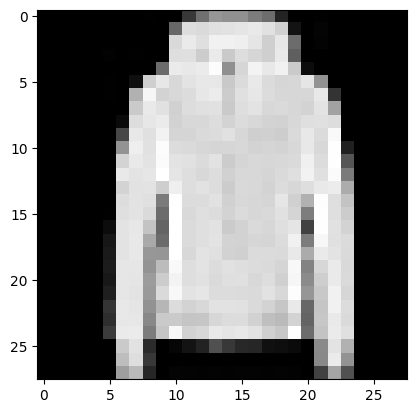

In [247]:
plt.imshow(img.squeeze(), cmap='gray')  

In [248]:
rand_image_tensor = torch.rand(size=(1, 28, 28))
rand_image_tensor = rand_image_tensor.to(device)

rand_image_tensor.shape

torch.Size([1, 28, 28])

In [249]:
model_2(rand_image_tensor.unsqueeze(0))

tensor([[-0.0260, -0.0019, -0.0067, -0.0033, -0.0110, -0.0227,  0.0393, -0.0626,
         -0.0471, -0.0516]], device='cuda:0', grad_fn=<AddmmBackward0>)

## Training the model

In [250]:
from tqdm import tqdm

In [251]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [252]:
model_2 = FashionMNISTModelV2(
    input_shape=1,
    hidden_units=10,
    output_shape=len(class_names)
).to(device)

model_2

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [253]:
def accuracy_fn(y_pred, y_true):
    correct = torch.eq(y_pred, y_true).sum().item()
    acc = (correct / len(y_pred)) * 100

    return acc

def train_step(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_fn,
    device: torch.device = device
):
    train_loss, train_acc = 0, 0
    model.to(device)

    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(
    data_loader: torch.utils.data.DataLoader,
    model: torch.nn.Module,
    loss_fn: torch.nn.Module,
    accuracy_fn,
    device: torch.device = device
):
    test_loss, test_acc = 0, 0

    model.to(device)
    model.eval()

    with torch.inference_mode(): 
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            
            test_pred = model(X)
            
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [254]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

In [255]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer

EPOCHS = 10

start_time = timer()

for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch {epoch}\n--------------------------------------------------------------------------")
    train_step(
        model=model_2,
        data_loader=train_dataloader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(
        data_loader=test_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

end_time = timer()

total_train_time_model_2 = print_train_time(start_time, end_time, str(next(model_2.parameters()).device))

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0
--------------------------------------------------------------------------
Train loss: 0.60748 | Train accuracy: 77.81%


 10%|█         | 1/10 [00:10<01:34, 10.52s/it]

Test loss: 0.38655 | Test accuracy: 86.52%

Epoch 1
--------------------------------------------------------------------------
Train loss: 0.35071 | Train accuracy: 87.39%


 20%|██        | 2/10 [00:20<01:21, 10.14s/it]

Test loss: 0.33436 | Test accuracy: 87.93%

Epoch 2
--------------------------------------------------------------------------
Train loss: 0.31273 | Train accuracy: 88.69%


 30%|███       | 3/10 [00:30<01:11, 10.24s/it]

Test loss: 0.31395 | Test accuracy: 88.65%

Epoch 3
--------------------------------------------------------------------------
Train loss: 0.29167 | Train accuracy: 89.41%


 40%|████      | 4/10 [00:41<01:01, 10.31s/it]

Test loss: 0.31224 | Test accuracy: 88.86%

Epoch 4
--------------------------------------------------------------------------
Train loss: 0.28004 | Train accuracy: 89.96%


 50%|█████     | 5/10 [00:51<00:52, 10.48s/it]

Test loss: 0.29855 | Test accuracy: 89.09%

Epoch 5
--------------------------------------------------------------------------
Train loss: 0.26846 | Train accuracy: 90.31%


 60%|██████    | 6/10 [01:02<00:42, 10.64s/it]

Test loss: 0.29698 | Test accuracy: 89.81%

Epoch 6
--------------------------------------------------------------------------
Train loss: 0.26184 | Train accuracy: 90.50%


 70%|███████   | 7/10 [01:12<00:31, 10.43s/it]

Test loss: 0.32811 | Test accuracy: 88.33%

Epoch 7
--------------------------------------------------------------------------
Train loss: 0.25670 | Train accuracy: 90.73%


 80%|████████  | 8/10 [01:22<00:20, 10.31s/it]

Test loss: 0.28159 | Test accuracy: 89.77%

Epoch 8
--------------------------------------------------------------------------
Train loss: 0.24932 | Train accuracy: 91.08%


 90%|█████████ | 9/10 [01:33<00:10, 10.25s/it]

Test loss: 0.28948 | Test accuracy: 89.90%

Epoch 9
--------------------------------------------------------------------------
Train loss: 0.24497 | Train accuracy: 91.09%


100%|██████████| 10/10 [01:42<00:00, 10.24s/it]

Test loss: 0.29854 | Test accuracy: 89.65%

Training time on cuda:0: 102.412 seconds


In [256]:
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)

model_2_results

100%|██████████| 313/313 [00:01<00:00, 272.98it/s]


{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.2985358238220215,
 'model_accuracy': 89.64656549520767}

# Comparing the results

In [258]:
import pandas as pd

compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])

compare_results["training_time"] = [
    total_train_time_model_0,
    total_train_time_model_1,
    total_train_time_model_2
]

compare_results

,model_name,model_loss,model_accuracy,training_time
0,FashionMNISTModelV0,0.462798,83.646166,53.245115
1,FashionMNISTModelV1,0.673974,75.499201,79.241694
2,FashionMNISTModelV2,0.298536,89.646565,102.412143


Text(0, 0.5, 'Model')

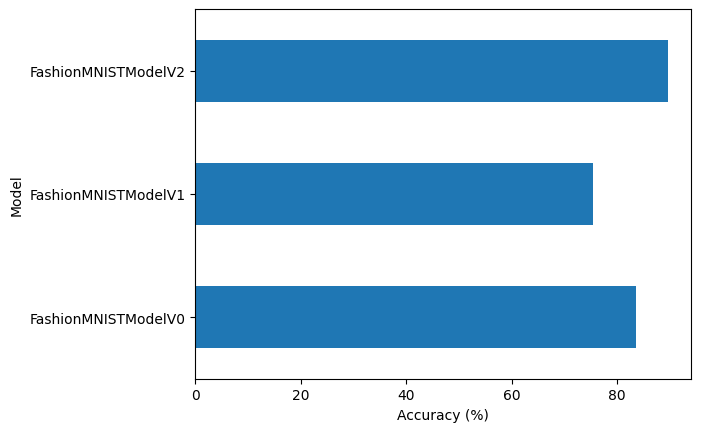

In [259]:
compare_results.set_index("model_name")["model_accuracy"].plot(kind="barh")
plt.xlabel("Accuracy (%)")
plt.ylabel("Model")

# Make and evaluate random predictions with best model

In [260]:
def make_predictions(
    model: nn.Module,
    data: list,
    device: torch.device = torch.device("cpu")
):
    pred_probas = []

    model.to(device)
    model.eval()

    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)
            pred_logit = model(sample)
            pred_proba = torch.softmax(pred_logit.squeeze(), dim=0)

            pred_probas.append(pred_proba.cpu())

    return torch.stack(pred_probas)

In [296]:
import random

random.seed(42)

test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), 9):
    test_samples.append(sample)
    test_labels.append(label)

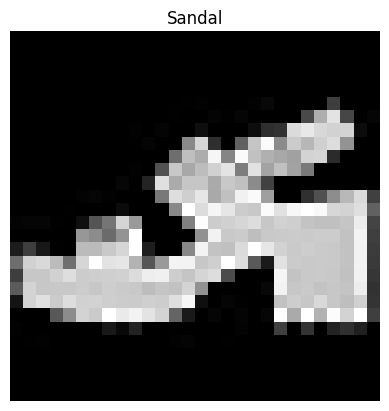

In [297]:
plt.imshow(test_samples[0].squeeze(), cmap='gray')
plt.title(class_names[test_labels[0]])
plt.axis('off')
plt.show()

In [300]:
pred_probas = make_predictions(model_2, test_samples, device)

pred_classes = pred_probas.argmax(dim=1)

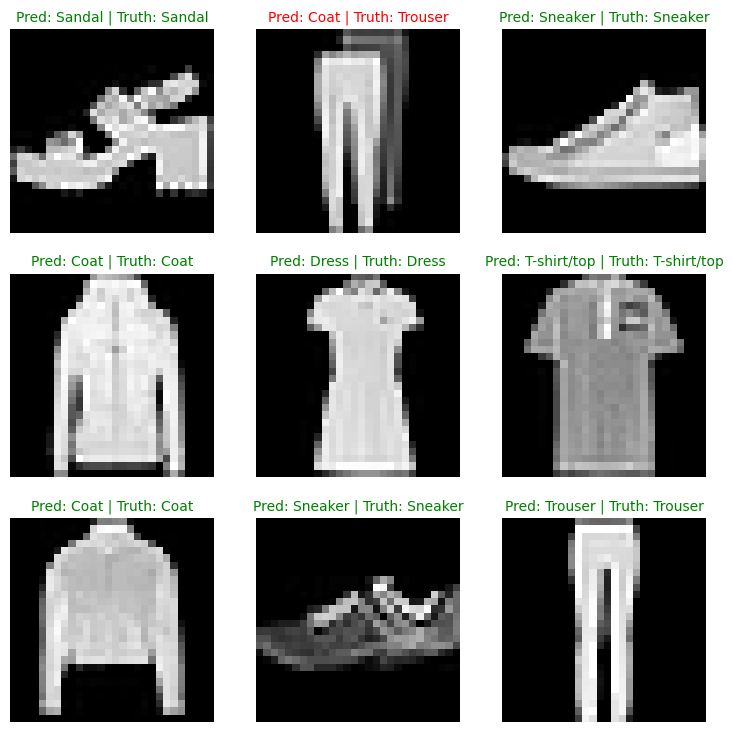

In [301]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]] 

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);